In [2140]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import numpy as np
import cvxopt as opt
from cvxopt import solvers, blas, matrix
from statsmodels.stats.correlation_tools import cov_nearest

%matplotlib inline
solvers.options['show_progress'] = False

# Markowitz Bullet and the Efficient Frontier

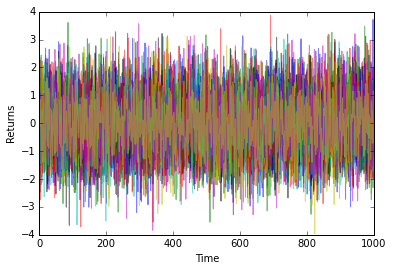

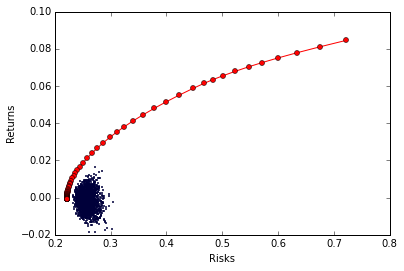

In [2181]:
n_obs = 1000
n_assets = 
min_return_goal = 0.09
returns = np.random.randn(n_assets, n_obs)


plt.plot(returns.T, alpha=.5)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()

def random_Weights(n_assets):
    w = np.random.rand(n_assets)
    w = w/sum(w)
    return w

def generate_portfolio(n_assets, returns):
    w = np.asmatrix(random_Weights(n_assets))
    cov_matrix = np.asmatrix(np.cov(returns))
    positions = np.asmatrix(np.mean(returns, axis=1))
    mean = w * positions.T
    risk = np.sqrt(w * cov_matrix * w.T)
    
    return mean, risk

n_portfolios = 2000
means, risks = np.column_stack([
    generate_portfolio(n_assets, returns) 
    for _ in xrange(n_portfolios)
])
    
def find_efficient_frontier(means, risks, n_assets, returns):
    means = np.asmatrix(means)
    risks = np.asmatrix(risks)
    S = opt.matrix(np.cov(returns))
    returns_ = opt.matrix(np.mean(returns, axis=1))
    
    N = 100
    sequence = [10**(5.0 * i/N - 1.0) for i in range(N)]
    
    G = -opt.matrix(np.eye(n_assets))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n_assets ,1))
    A = opt.matrix(1.0, (1, n_assets))
    b = opt.matrix(1.0)
    
    efficient_portfolio = [solvers.qp(_sequence_*S, -returns_, G, h, A, b)['x'] for _sequence_ in sequence]
    
    efficient_portfolio_means = [ blas.dot(returns_,i) for i in efficient_portfolio ]
    efficient_portfolio_risks = [ np.sqrt(blas.dot(i,S*i))
                                 for i in efficient_portfolio ]
    
    return efficient_portfolio_means, efficient_portfolio_risks

means_opt, risks_opt = find_efficient_frontier(means, risks, n_assets, returns)


plt.plot(risks_opt, means_opt, 'r-o', markersize=5)
plt.xlabel('Risks')
plt.ylabel('Returns')
plt.plot(risks, means, 'o', markersize=1.5)
plt.show()

## Optimizing a Given Portfolio

### Initialize

Our portfolio is: 
['ads', 'icln', 't']


4000 randomly allocated portfolios:


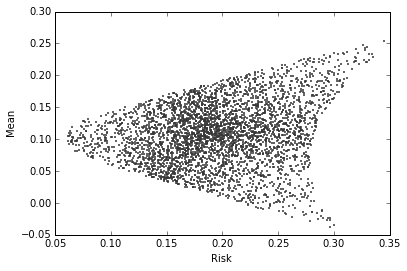

Performance of: ads


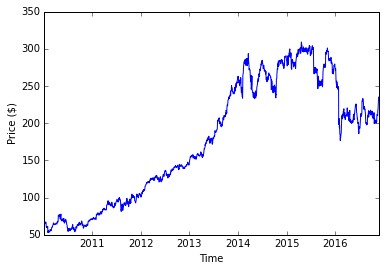

Performance of: icln


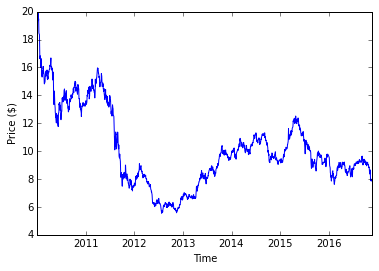

Performance of: t


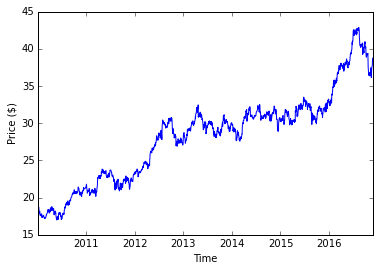

In [2163]:
start = datetime.date(2010,1,1)
end = datetime.datetime.now()

#portfolio = ['ads','icln','t','etp']
#portfolio = ['ads','icln','t']
#portfolio = ['tsm','msft','dis','t']
#portfolio = ['hst','bac','dd','hes','stj']
#portfolio = ['tsm','luv','etp','mos','goog','t'] 
#portfolio = ['GOOG', 'AIMC', 'GS', 'BH', 'F', 'HLS', 'DIS', 'LUV','MSFT'] 
#portfolio = ['ADS','BK','ETP','ICLN', 'IP', 'MOS', 'T', 'TM', 'TSM']
#portfolio = ['GOOG', 'AIMC', 'GS', 'BH', 'F', 'HLS', 'DIS', 'LUV','MSFT',
#           'ADS','BK','ETP','ICLN', 'IP', 'MOS', 'T', 'TM']
portfolio.sort()

portfolioCloses = web.DataReader(portfolio, 'yahoo', start, end)['Adj Close']
portfolioCloses = portfolioCloses.resample('A',how='last')
portfolioCloses = portfolioCloses.pct_change().dropna()
portfolioCloses = np.array(portfolioCloses.T)

expectedReturns = web.DataReader(portfolio, 'yahoo', start, end)['Adj Close']
expectedReturns = expectedReturns.resample('A',how='last').pct_change().dropna().T

expectedReturns1 = matrix([np.mean(yr_returns) for yr_returns in portfolioCloses])

expectedReturns2 = web.DataReader(portfolio, 'yahoo', start, end)['Adj Close']
expectedReturns2 = expectedReturns2.pct_change().dropna().T


    
def plot_Performances():
    for tickers in portfolio:
        closes = stocks_Close(tickers)
        dates = closes.index
        print "Performance of: " + tickers
        plt.plot(dates, closes)
        plt.ylabel('Price ($)')
        plt.xlabel('Time')
        plt.show()

# Print our portfolio
print "Our portfolio is: "
print portfolio

print "\n"

### Print the portfolio opportunity set
n = 4000
mean, risk = np.column_stack([
    generate_portfolio(len(portfolio), expectedReturns) 
    for _ in xrange(n)
])
print "4000 randomly allocated portfolios:"
plt.plot(risk, mean, 'o', color='.95', markersize=1.5, label='Randomly Generated Portfolios')
plt.ylabel('Mean')
plt.xlabel('Risk')
plt.show()

### Plot the performance of our individual assets over our time period
plot_Performances()

### Set Up the Optimization Problem 

In [2179]:
r_min = .35


cov = np.cov(expectedReturns2)
cov = matrix(cov)


q = matrix(np.zeros((len(portfolio),1)))
print "q: "
print q


h = matrix(np.concatenate((
             -np.ones((1,1))*r_min, 
              np.zeros((len(portfolio),1))), 0))
print "h: "
print h


G = matrix(np.concatenate((
             -np.transpose(expectedReturns1), 
             -np.identity(len(portfolio))), 0))
print "G: "
print G


A = np.ones((1,len(portfolio)))
A = A.astype(np.double())
A = matrix(A)
print "A: "
print A

b = matrix(1.0)
print b


q: 
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]

h: 
[-3.50e-01]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]

G: 
[-2.63e-01  4.32e-02 -1.06e-01]
[-1.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -1.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -1.00e+00]

A: 
[ 1.00e+00  1.00e+00  1.00e+00]

[ 1.00e+00]



### Solve for Optimal Portfolio Weights 

In [2180]:
# Use cvxopt solvers package to solve the convex optimation problem,
# solving for the weights of each asset.
sol = solvers.qp(cov, q, G, h, A, b)['x']


# Format weights into an array
weights = []
for i in range(0, len(sol)):
    weights.append(sol[i])

ValueError: domain error

### Visualizing our Results

The weights in our optimal portfolio are: 
[0.9054493390406563, 0.04511521811038908, 0.38594626670449034]


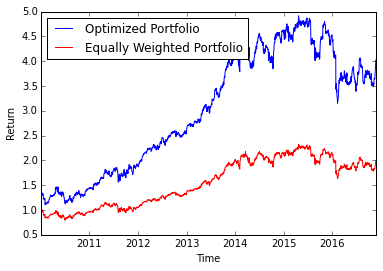

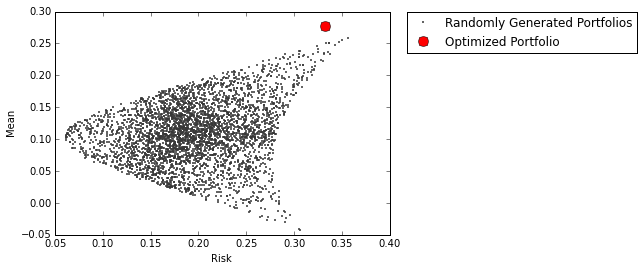

Does this portfolio meet all constraints?
The average yearly return for the optimal portfolio is: 0.2772
Our minimum allowed expected return was: 0.3
The sum of the weights in the portfolio equals:  1.33651082386


In [2178]:
##### Print the weights
print "The weights in our optimal portfolio are: "
print weights


### Graph portfolios performance over time
weights = np.array(weights)
weightsEqual = np.ones(len(portfolio)) / len(portfolio)

dailyClosesDF = web.DataReader(portfolio, 'yahoo', start, end)['Adj Close']
dailyCloses = np.array(dailyClosesDF)

shares = np.zeros(len(dailyCloses[0]))
sharesEqual = np.zeros(len(dailyCloses[0]))
for i in range(0,len(dailyCloses[0])):
    shares[i] = weights[i] / dailyCloses[0][i]
    sharesEqual[i] = weightsEqual[i] / dailyCloses[0][i]

portfolioValue = np.zeros(len(dailyCloses))
portfolioValueEqual = np.zeros(len(dailyCloses))
for i in range(0, len(dailyCloses)):
    for j in range(0, len(dailyCloses[0])):
        portfolioValue[i] += shares[j] * dailyCloses[i][j] 
        portfolioValueEqual[i] += sharesEqual[j] * dailyCloses[i][j]

plt.plot(dailyClosesDF.index, portfolioValue, label='Optimized Portfolio')
plt.plot(dailyClosesDF.index, portfolioValueEqual, color='red', label='Equally Weighted Portfolio')
plt.ylabel('Return')
plt.xlabel('Time')
plt.legend(loc=2)
plt.show()

#plot_Performances()



### Get means and risks for n randomly constucted portfolios
n = 4000
mean, risk = np.column_stack([
    generate_portfolio(len(portfolio), expectedReturns) 
    for _ in xrange(n)
])



### Get the average one year return and risk for the optimal portfolio
def one_Period_Returns(weights, returns):
    w = np.asmatrix(weights)
    cov_matrix = np.array(np.cov(returns))
    positions = np.asmatrix(np.average(returns, axis=1))
    
    mean = (w * positions.T)
    risk = np.sqrt((w * cov_matrix * w.T))
    
    return mean, risk

returnsOptimal, riskOptimal = one_Period_Returns(weights, expectedReturns)




### Plot the optimal portfolio alongside the n randomly generated portfolios
#if r_min < returnsOptimal:
plt.plot(risk, mean, 'o', color='.95', markersize=1.5, label='Randomly Generated Portfolios')
plt.plot(riskOptimal, returnsOptimal, 'ro', markersize=10, label='Optimized Portfolio')
plt.ylabel('Mean')
plt.xlabel('Risk')
axes = plt.gca()
axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., numpoints=1)
plt.show()


### Check that our original constraints are met
print "Does this portfolio meet all constraints?"
forString1 = round(np.array(returnsOptimal)[0][0], 4)
forString2 = round(np.array(riskOptimal)[0][0], 4)
print "The average yearly return for the optimal portfolio is: {}".format(forString1)
print "Our minimum allowed expected return was: {}".format(r_min)
'''print "The risk of this optimal portfolio is: {}".format(forString2)'''
sumWeights = 0
for i in weights:
    sumWeights += i
print "The sum of the weights in the portfolio equals: " , sumWeights

Notes:
    - Assets with crazy high returns and very little variance tend to lead to not so pretty visuals.
        - this is because if one stock in the portfolio has much higher returns and has grown consistantly over the             timeframe, our optimal porfolio will be weighted very heavily towards this stock
    - When our r_min approaches the minimum variance portfolio, this program breaks down.
    - A nice bullet shape breaks down with added assets in portfolio b/c normal distribution of weights cant handle
      all the possibilities needed to represent the complete portfolio opportunity set.
         - Magic number of assets such that the portfolio opportunity set still has an identifiable bullet shape: 6